In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import GroupShuffleSplit
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.inspection import permutation_importance

In [67]:
# 1. Cargar los datos
train = pd.read_csv('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv')
oot = pd.read_csv('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/prueba_op_base_pivot_var_rpta_alt_enmascarado_oot.csv')
prob = pd.read_csv('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/prueba_op_probabilidad_oblig_base_hist_enmascarado_completa.csv')
master = pd.read_csv('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/prueba_op_master_customer_data_enmascarado_completa.csv')
pagos = pd.read_csv('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/prueba_op_maestra_cuotas_pagos_mes_hist_enmascarado_completa.csv')
sample_sub = pd.read_csv('C:/Users/boris/OneDrive/Desktop/Coding/Test/data/sample_submission.csv')


In [68]:
# 2. Mostrar dimensiones de cada set
shapes = pd.DataFrame({
    'Dataset': ['train', 'oot', 'prob', 'master', 'pagos'],
    'Rows': [train.shape[0], oot.shape[0], prob.shape[0], master.shape[0],pagos.shape[0]],
    'Columns': [train.shape[1], oot.shape[1], prob.shape[1], master.shape[1], pagos.shape[1]]
})
print("Dimensiones de los datasets:")
display(shapes)

# 3. Inspección de columnas y primeras filas de train y master
print("\nColumnas de train:")
print(train.columns.tolist())
print("\nPrimeras 5 filas de train:")
display(train.head())

print("\nColumnas de prob:")
print(prob.columns.tolist())
print("\nPrimeras 5 filas de prob:")
display(prob.head())

print("\nColumnas de master:")
print(master.columns.tolist())
print("\nPrimeras 5 filas de master:")
display(master.head())

print("\nColumnas de pagos:")
print(pagos.columns.tolist())
print("\nPrimeras 5 filas de pagos:")
display(pagos.head())



Dimensiones de los datasets:


,Dataset,Rows,Columns
0,train,568251,49
1,oot,112549,4
2,prob,4804836,7
3,master,430000,37
4,pagos,4855035,13



Columnas de train:
['nit_enmascarado', 'num_oblig_orig_enmascarado', 'num_oblig_enmascarado', 'fecha_var_rpta_alt', 'var_rpta_alt', 'tipo_var_rpta_alt', 'banca', 'segmento', 'producto', 'producto_cons', 'aplicativo', 'min_mora', 'max_mora', 'dias_mora_fin', 'rango_mora', 'vlr_obligacion', 'vlr_vencido', 'saldo_capital', 'endeudamiento', 'desc_alternativa1', 'desc_alternativa2', 'desc_alternativa3', 'cant_alter_posibles', 'alter_posible1_2', 'alter_posible2_2', 'alter_posible3_2', 'cant_gestiones', 'cant_gestiones_binario', 'rpc', 'promesas_cumplidas', 'cant_promesas_cumplidas_binario', 'cant_acuerdo', 'cant_acuerdo_binario', 'descripcion_ranking_mejor_ult', 'descripcion_ranking_post_ult', 'marca_alt_rank', 'marca_alt_apli', 'valor_cuota_mes', 'pago_cuota', 'porc_pago_cuota', 'pago_mes', 'porc_pago_mes', 'pagos_tanque', 'marca_debito_mora', 'alternativa_aplicada_agr', 'marca_agrupada_rgo', 'marca_pago', 'marca_alternativa', 'marca_alternativa_orig']

Primeras 5 filas de train:


,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,var_rpta_alt,tipo_var_rpta_alt,banca,segmento,producto,producto_cons,...,porc_pago_cuota,pago_mes,porc_pago_mes,pagos_tanque,marca_debito_mora,alternativa_aplicada_agr,marca_agrupada_rgo,marca_pago,marca_alternativa,marca_alternativa_orig
0,630611,219718,863073,202308,1,a_uno_tipo_1,Banca Personas,Personal,TARJETA DE CREDITO,Tarjeta de Credito,...,0.095438,0.0,0.000000,Sin pago,NO,CONSOLIDACION,REESTRUCTURACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa
1,59412,789567,290775,202312,1,a_uno_tipo_1,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,...,0.000000,0.0,NaN,Sin pago,NO,PRORROGA,MANTENIMIENTO,Sin pago,Acepta Alternativa,Acepta Alternativa
2,277595,1045909,34433,202312,1,b_uno_tipo_2,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,...,0.000000,0.0,NaN,Sin pago,NO,NaN,NaN,Sin pago,Acepta Alternativa,Acepta Alternativa
3,26897,585786,494556,202311,1,a_uno_tipo_1,Banca Personas,Personal,ROTATIVOS,Rotativos,...,0.042117,4090.0,0.015324,Con pago,NO,PRORROGA,MANTENIMIENTO,Pago parcial,Acepta Alternativa,Acepta Alternativa
4,24588,1061389,18953,202311,1,b_uno_tipo_2,Banca Personas,Personal plus,ROTATIVOS,Rotativos,...,0.000000,0.0,0.000000,Sin pago,NO,CONSOLIDACION,REESTRUCTURACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa



Columnas de prob:
['nit_enmascarado', 'num_oblig_enmascarado', 'fecha_corte', 'lote', 'prob_propension', 'prob_alrt_temprana', 'prob_auto_cura']

Primeras 5 filas de prob:


,nit_enmascarado,num_oblig_enmascarado,fecha_corte,lote,prob_propension,prob_alrt_temprana,prob_auto_cura
0,296482,102381,202308,1,0.761350,0.193744,0.684784
1,391957,742315,202310,2,0.741803,0.384184,0.483696
2,229894,359919,202307,1,0.835373,0.285157,0.826225
3,478963,239064,202303,3,0.445002,0.629652,0.346508
4,349609,923348,202308,2,0.784365,0.419123,0.667603



Columnas de master:
['nit_enmascarado', 'cod_tipo_doc', 'tipo_cli', 'ctrl_terc', 'genero_cli', 'ano_nac_cli', 'edad_cli', 'estado_civil', 'tipo_vivienda', 'num_hijos', 'personas_dependientes', 'nivel_academico', 'ocup', 'act_econom', 'sector', 'subsector', 'declarante', 'total_ing', 'tot_activos', 'tot_pasivos', 'origen_fondos', 'f_vinc', 'f_ult_mantenimiento', 'canal_actualizacion', 'cli_actualizado', 'segm', 'subsegm', 'nicho', 'region_of', 'nombre_dpto_dirp', 'egresos_mes', 'tot_patrimonio', 'ciiu', 'smmlv', 'year', 'month', 'ingestion_day']

Primeras 5 filas de master:


,nit_enmascarado,cod_tipo_doc,tipo_cli,ctrl_terc,genero_cli,ano_nac_cli,edad_cli,estado_civil,tipo_vivienda,num_hijos,...,nicho,region_of,nombre_dpto_dirp,egresos_mes,tot_patrimonio,ciiu,smmlv,year,month,ingestion_day
0,536377,1,PERSONA NATURAL,CLIENTE,F,1998.0,25.0,SOLTERO,FAMILIAR,0.0,...,MUJERES,CENTRO,SANTANDER,0.0,33750000.0,NaN,1160000.0,2023,12,31
1,512257,1,PERSONA NATURAL,CLIENTE,F,1984.0,38.0,UNION LIBRE,PROPIA,0.0,...,MUJERES,CARIBE,MAGDALENA,250000.0,5000000.0,ASALARIADOS,1160000.0,2023,9,30
2,5788,1,PERSONA NATURAL,CLIENTE SOCIAL,M,1960.0,63.0,NaN,NaN,0.0,...,NaN,DIRECCIÓN GENERAL,SIN INFORMACION,0.0,0.0,ASALARIADOS,1160000.0,2023,11,30
3,132245,1,PERSONA NATURAL,CLIENTE,F,1982.0,41.0,CASADO,NaN,1.0,...,MUJERES,SUR,VALLE,1000000.0,62513000.0,ASALARIADOS,1160000.0,2023,7,31
4,245279,1,PERSONA NATURAL,CLIENTE,M,1980.0,43.0,CASADO,ALQUILADA,0.0,...,NaN,BOGOTA Y CUNDINAMARCA,CALDAS,1000000.0,34135000.0,ASALARIADOS,1160000.0,2023,12,31



Columnas de pagos:
['nit_enmascarado', 'num_oblig_enmascarado', 'fecha_corte', 'producto', 'aplicativo', 'segmento', 'valor_cuota_mes', 'pago_total', 'fecha_pago_minima', 'fecha_pago_maxima', 'porc_pago', 'marca_pago', 'ajustes_banco']

Primeras 5 filas de pagos:


,nit_enmascarado,num_oblig_enmascarado,fecha_corte,producto,aplicativo,segmento,valor_cuota_mes,pago_total,fecha_pago_minima,fecha_pago_maxima,porc_pago,marca_pago,ajustes_banco
0,482906,362297,20230731,CARTERA MICROCREDITO,L,MICROPYME,311950.0,1862788.0,20230621.0,20230721.0,597.0,PAGO_MENOS,NO
1,121735,186855,20230228,LIBRE INVERSION,L,SOCIAL,131030.0,264157.0,20230127.0,20230207.0,202.0,PAGO_MENOS,NO
2,582719,675503,20231031,TARJETA DE CREDITO,K,PERSONAL,1405339.0,3320.0,20231003.0,20231003.0,0.0,PAGO_MENOS,NO
3,299903,107931,20230228,ROTATIVOS,L,PERSONAL PLUS,19220.0,0.0,NaN,NaN,0.0,FACTURACION_MES_SGTE,NO
4,88625,566060,20230430,ROTATIVOS,L,PERSONAL,384684.0,769368.0,20230403.0,20230403.0,200.0,PAGO_MAS,NO


### Preparacion de los dataframes

In [69]:

# 2️⃣ Agregado de probabilidades con manejo de NaNs
# 👉 Unimos train + historiales
prob_ext = (
    train[['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_alt']]
    .merge(prob, on=['nit_enmascarado','num_oblig_enmascarado'], how='left')
)

# 👉 Convertir a numérico y eliminar rows sin fecha_corte o fecha_var_rpta_alt
prob_ext['fecha_corte'] = pd.to_numeric(prob_ext['fecha_corte'], errors='coerce')
prob_ext['fecha_var_rpta_alt'] = pd.to_numeric(prob_ext['fecha_var_rpta_alt'], errors='coerce')
prob_ext = prob_ext.dropna(subset=['fecha_corte','fecha_var_rpta_alt'])

# 👉 Filtrar solo históricos previos al mes de evaluación
prob_ext = prob_ext[prob_ext['fecha_corte'] < prob_ext['fecha_var_rpta_alt']]

# 👉 Calcular estadísticas
prob_agg = (
    prob_ext
    .groupby(['nit_enmascarado','num_oblig_enmascarado'])
    .agg(
        prop_last   = ('prob_propension', 'last'),
        prop_mean3  = ('prob_propension', lambda x: x.tail(3).mean()),
        auto_mean3  = ('prob_auto_cura',   lambda x: x.tail(3).mean()),
    )
    .reset_index()
)

# 3️⃣ Merge con train
train_feat = train.merge(
    prob_agg,
    on=['nit_enmascarado','num_oblig_enmascarado'],
    how='left'
)

# 4️⃣ Agregado de pagos (3 meses)
pagos['fecha_corte'] = pd.to_datetime(pagos['fecha_corte'], format='%Y%m%d')
train_feat['fecha_var_rpta_dt'] = pd.to_datetime(
    train_feat['fecha_var_rpta_alt'].astype(int).astype(str) + '01', format='%Y%m%d'
)
pag_ext = (
    train_feat[['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_dt']]
    .merge(pagos, on=['nit_enmascarado','num_oblig_enmascarado'], how='left')
)
pag_ext = pag_ext[pag_ext['fecha_corte'] < pag_ext['fecha_var_rpta_dt']]
pag_ext = pag_ext.sort_values('fecha_corte').groupby(
    ['nit_enmascarado','num_oblig_enmascarado']
).tail(3)
pag_agg = pag_ext.groupby(['nit_enmascarado','num_oblig_enmascarado']).agg(
    pct_pago_mean = ('porc_pago','mean'),
    pagos_count3   = ('porc_pago','count'),
).reset_index()
train_feat = train_feat.merge(pag_agg, on=['nit_enmascarado','num_oblig_enmascarado'], how='left')

# 5️⃣ Merge datos maestro
train_feat = train_feat.merge(master, on=['nit_enmascarado'], how='left')
train_feat.drop(columns=['fecha_var_rpta_dt'], inplace=True)

# 6️⃣ Split Train/Validation (sin IDs repetidos)
train_feat['group_id'] = (
    train_feat['nit_enmascarado'].astype(str)
    + '#'
    + train_feat['num_oblig_enmascarado'].astype(str)
)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(train_feat, groups=train_feat['group_id']))
df_train = train_feat.iloc[train_idx].drop(columns=['group_id'])
df_val   = train_feat.iloc[val_idx].drop(columns=['group_id'])

# 7️⃣ Preparación de OOT (mismo prob_agg y pag_agg)
oot_feat = (
    oot
    .merge(prob_agg, on=['nit_enmascarado','num_oblig_enmascarado'], how='left')
    .merge(pag_agg,  on=['nit_enmascarado','num_oblig_enmascarado'], how='left')
    .merge(master,   on=['nit_enmascarado'],                     how='left')
)


# Mostrar shapes
print("Train shape:      ", df_train.shape)
print("Validation shape: ", df_val.shape)
print("OOT shape:        ", oot_feat.shape)


Train shape:       (740462, 90)
Validation shape:  (184684, 90)
OOT shape:         (183255, 45)


In [70]:

# Eliminar decimales y convertir a string sin ".0"
#    Esto funciona tanto si el valor era float con .0 como si ya era entero
train_feat['f_vinc_str'] = train_feat['f_vinc'].astype(str).str.replace(r'\.0$', '', regex=True)
train_feat['f_ult_mant_str'] = train_feat['f_ult_mantenimiento'].astype(str).str.replace(r'\.0$', '', regex=True)

# Parsear directamente a datetime con formato YYYYMMDD
train_feat['f_vinc_date'] = pd.to_datetime(
    train_feat['f_vinc_str'], format='%Y%m%d', errors='coerce'
)
train_feat['f_ult_mant_date'] = pd.to_datetime(
    train_feat['f_ult_mant_str'], format='%Y%m%d', errors='coerce'
)

# Crear fecha de evaluación (primer día del mes)
train_feat['fecha_var_rpta_dt'] = pd.to_datetime(
    train_feat['fecha_var_rpta_alt'].astype(int).astype(str) + '01',
    format='%Y%m%d', errors='coerce'
)

# Calcular años transcurridos
train_feat['years_since_vinc'] = (
    (train_feat['fecha_var_rpta_dt'] - train_feat['f_vinc_date']).dt.days / 365.25
).round(2)
train_feat['years_since_ult_mant'] = (
    (train_feat['fecha_var_rpta_dt'] - train_feat['f_ult_mant_date']).dt.days / 365.25
).round(2)

# Verificar resultados
print(train_feat[
    ['nit_enmascarado','num_oblig_enmascarado',
     'f_vinc','f_vinc_date','years_since_vinc',
     'f_ult_mantenimiento','f_ult_mant_date','years_since_ult_mant']
].head())


   nit_enmascarado  num_oblig_enmascarado      f_vinc f_vinc_date  \
0           630611                 863073  20200629.0  2020-06-29   
1            59412                 290775  20180829.0  2018-08-29   
2           277595                  34433  19870810.0  1987-08-10   
3           277595                  34433  19870810.0  1987-08-10   
4            26897                 494556         NaN         NaT   

   years_since_vinc  f_ult_mantenimiento f_ult_mant_date  years_since_ult_mant  
0              3.09           20230927.0      2023-09-27                 -0.16  
1              5.26           20231124.0      2023-11-24                  0.02  
2             36.31           20230825.0      2023-08-25                  0.27  
3             36.31           20231011.0      2023-10-11                  0.14  
4               NaN                  NaN             NaT                   NaN  


### EDA

Porcentaje de valores faltantes (top 20):
tipo_vivienda            0.710004
nivel_academico          0.602797
nicho                    0.584008
canal_actualizacion      0.207188
estado_civil             0.188746
sector                   0.183917
subsector                0.183917
ciiu                     0.183917
act_econom               0.181124
ocup                     0.167752
subsegm                  0.148203
genero_cli               0.143452
personas_dependientes    0.143422
edad_cli                 0.143418
num_hijos                0.143418
ano_nac_cli              0.143418
origen_fondos            0.131153
nombre_dpto_dirp         0.123744
declarante               0.121325
segm                     0.121047
dtype: float64

Estadísticas descriptivas (numéricas):
       fecha_var_rpta_alt      prop_last     prop_mean3     auto_mean3  \
count       925146.000000  923004.000000  923004.000000  923004.000000   
mean        202309.946027       0.740498       0.740222       0.530465   
s

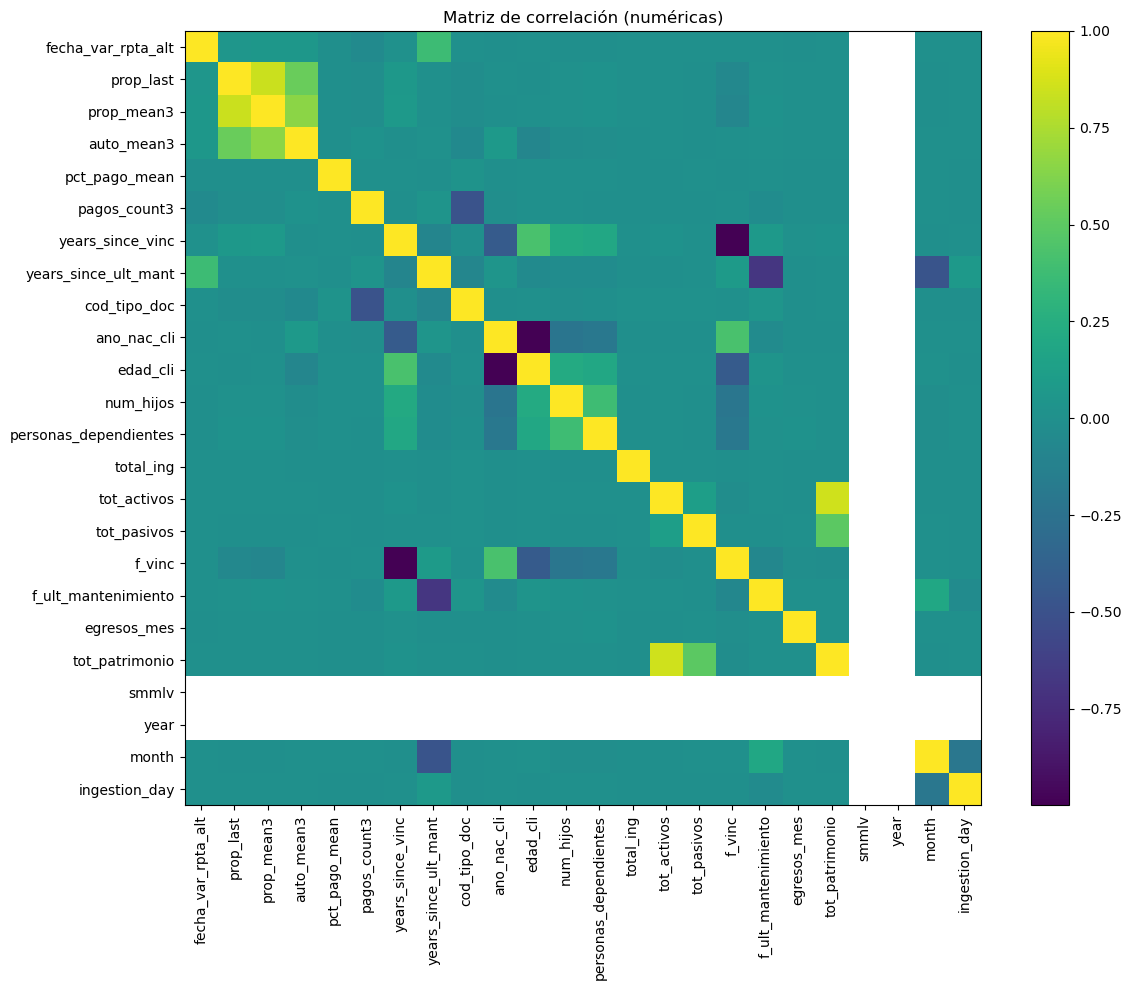

In [71]:

# Definir columnas a mantener
agg_cols = ['prop_last','prop_mean3','auto_mean3','pct_pago_mean','pagos_count3', 'years_since_vinc', 'years_since_ult_mant']
demog_cols = [col for col in master.columns if col != 'nit_enmascarado']
final_cols = ['fecha_var_rpta_alt'] + agg_cols + demog_cols + ['var_rpta_alt'] 

df_train2 = train_feat[final_cols]
df_train2v1 = df_train2.copy()

# 1️⃣ Valores faltantes
missing_pct = df_train2.isna().mean().sort_values(ascending=False)
print("Porcentaje de valores faltantes (top 20):")
print(missing_pct.head(20))

# 2️⃣ Estadísticas descriptivas
print("\nEstadísticas descriptivas (numéricas):")
print(df_train2.describe())

# 3️⃣ Cardinalidad de categóricas
cat_feats = df_train2.select_dtypes(include=['object','category']).columns.tolist()
cardinality = df_train2[cat_feats].nunique().sort_values(ascending=False)
print("\nCardinalidad (número de categorías) por variable categórica:")
print(cardinality)

# 4️⃣ Matriz de correlación entre numéricas
num_feats = df_train2.select_dtypes(include=[np.number]).drop(columns=['var_rpta_alt'])
corr = num_feats.corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Matriz de correlación (numéricas)")
plt.tight_layout()
plt.show()

Columnas con >20% de missing y que se eliminarán:
['tipo_vivienda', 'nivel_academico', 'canal_actualizacion', 'nicho']
Columnas eliminadas manualmente: ['ano_nac_cli', 'f_vinc', 'f_ult_mantenimiento', 'year', 'month', 'ingestion_day', 'smmlv', 'fecha_var_rpta_alt']
df shape (925146, 33)

Valores faltantes tras eliminación (top 20):
estado_civil             0.188746
subsector                0.183917
ciiu                     0.183917
sector                   0.183917
act_econom               0.181124
ocup                     0.167752
subsegm                  0.148203
genero_cli               0.143452
personas_dependientes    0.143422
num_hijos                0.143418
edad_cli                 0.143418
origen_fondos            0.131153
nombre_dpto_dirp         0.123744
declarante               0.121325
segm                     0.121047
cli_actualizado          0.121020
tipo_cli                 0.121020
region_of                0.121020
tot_pasivos              0.121020
tot_activos         

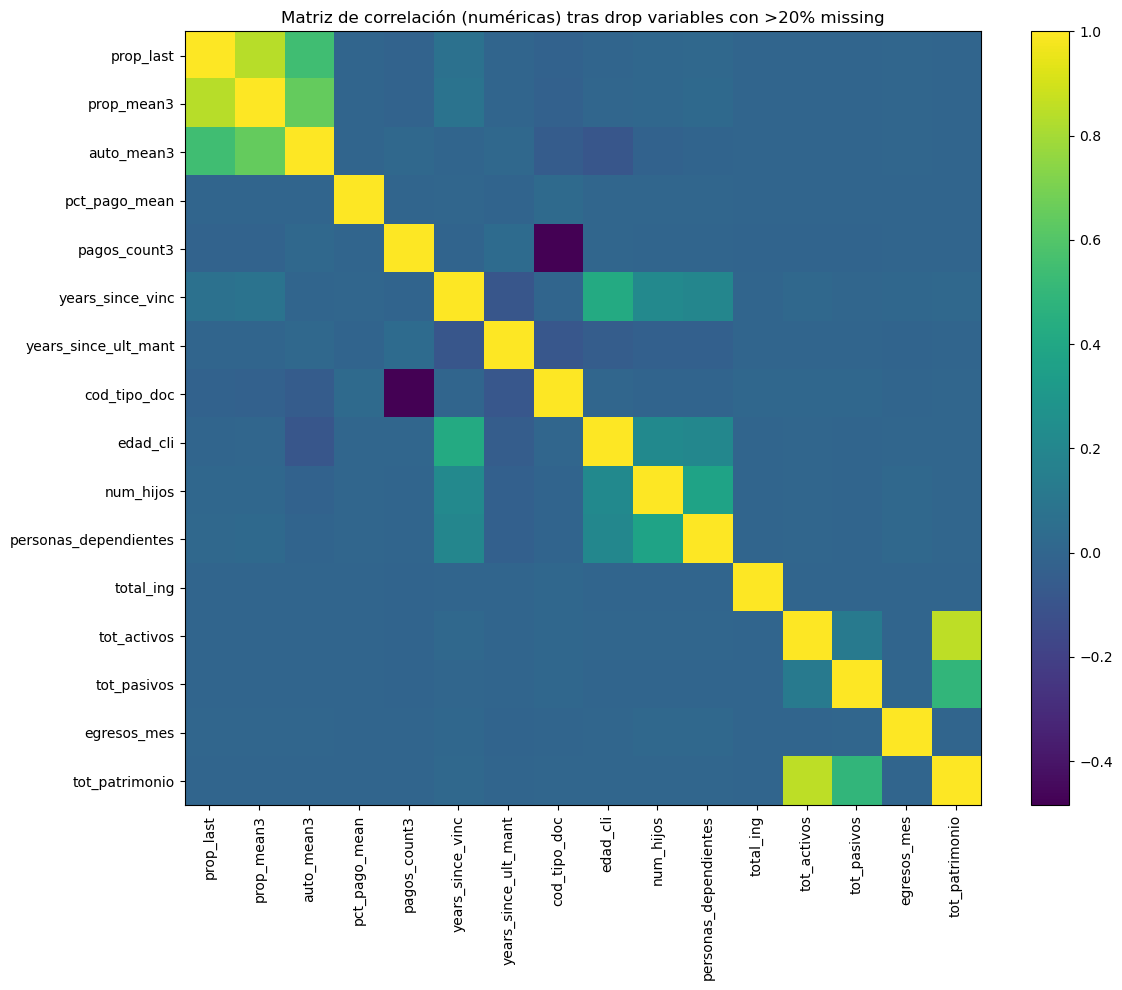

In [72]:
# Seleccion de variables relevantes

# Identificar y eliminar columnas con >20% de valores faltantes
missing_pct = df_train2.isna().mean()
to_drop = missing_pct[missing_pct > 0.2].index.tolist()
print("Columnas con >20% de missing y que se eliminarán:")
print(to_drop)

df_train2 = df_train2.drop(columns=to_drop)

# Eliminar variables no representativas y alta cardinalidad
drop_specific = [
    'ano_nac_cli', 'f_vinc', 'f_ult_mantenimiento',
    'year', 'month', 'ingestion_day', 'smmlv','fecha_var_rpta_alt'
]
df_train2.drop(columns=drop_specific, errors='ignore', inplace=True)
print("Columnas eliminadas manualmente:", drop_specific)


print(f'df shape {df_train2.shape}')
# 4️⃣ EDA sobre el dataset limpio

# 4.1️⃣ Valores faltantes (post-drop)
print("\nValores faltantes tras eliminación (top 20):")
print(df_train2.isna().mean().sort_values(ascending=False).head(20))


# 4.2️⃣ Estadísticas descriptivas
print("\nEstadísticas descriptivas (numéricas):")
print(df_train2.describe())

# 4.3️⃣ Cardinalidad de categóricas
cat_feats = df_train2.select_dtypes(include=['object','category']).columns.tolist()
print("\nCardinalidad por variable categórica:")
print(df_train2[cat_feats].nunique().sort_values(ascending=False))

# 4.4️⃣ Matriz de correlación numérica
num_feats = df_train2.select_dtypes(include=[np.number]).drop(columns=['var_rpta_alt'], errors='ignore')
corr = num_feats.corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Matriz de correlación (numéricas) tras drop variables con >20% missing")
plt.tight_layout()
plt.show()



In [73]:

# 1️⃣ Identificar variables categóricas
cat_feats = df_train2.select_dtypes(include=['object','category']).columns.tolist()

# 2️⃣ Calcular cardinalidad de cada categórica
cardinality = df_train2[cat_feats].nunique()

# 3️⃣ Seleccionar aquellas con cardinalidad > 5
high_card = cardinality[cardinality > 5].index.tolist()
print("Variables categóricas con cardinalidad > 5 (a eliminar):")
print(high_card)

# 4️⃣ Eliminar del DataFrame
df_train2.drop(columns=high_card, inplace=True)

# 5️⃣ Verificar resultado
print("\nNuevo shape de df_train2:", df_train2.shape)
print("Categorías restantes con su cardinalidad:")
print(df_train2.select_dtypes(include=['object','category']).nunique())


Variables categóricas con cardinalidad > 5 (a eliminar):
['ctrl_terc', 'estado_civil', 'ocup', 'act_econom', 'sector', 'subsector', 'origen_fondos', 'segm', 'subsegm', 'region_of', 'nombre_dpto_dirp', 'ciiu']

Nuevo shape de df_train2: (925146, 21)
Categorías restantes con su cardinalidad:
tipo_cli           2
genero_cli         2
declarante         2
cli_actualizado    2
dtype: int64


In [74]:
cat_feats = df_train2.select_dtypes(include=['object','category']).columns.tolist()

# 3️⃣ Filtrar sólo las de cardinalidad 2
binary_feats = [col for col in cat_feats if df_train2[col].nunique(dropna=True) == 2]
print("Variables binarias a codificar:", binary_feats)

# 4️⃣ Mapear cada variable binaria a 0/1
for col in binary_feats:
    vals = df_train2[col].dropna().unique().tolist()
    mapping = {vals[0]: 0, vals[1]: 1}
    df_train2[col] = df_train2[col].map(mapping)

# 5️⃣ Verificar que no quedan categóricas binarias
remaining = [c for c in binary_feats if df_train2[c].dtype == 'object']
print("Quedan variables objet de cardinalidad 2 sin codificar:", remaining)

Variables binarias a codificar: ['tipo_cli', 'genero_cli', 'declarante', 'cli_actualizado']
Quedan variables objet de cardinalidad 2 sin codificar: []


In [75]:
df_train2.dtypes

prop_last                float64
prop_mean3               float64
auto_mean3               float64
pct_pago_mean            float64
pagos_count3             float64
years_since_vinc         float64
years_since_ult_mant     float64
cod_tipo_doc             float64
tipo_cli                 float64
genero_cli               float64
edad_cli                 float64
num_hijos                float64
personas_dependientes    float64
declarante               float64
total_ing                float64
tot_activos              float64
tot_pasivos              float64
cli_actualizado          float64
egresos_mes              float64
tot_patrimonio           float64
var_rpta_alt               int64
dtype: object

In [ ]:
# Identificar variables binarias (0/1) excluyendo target
binary_feats = [
    col for col in df_train2.select_dtypes(include=[int, float]).columns
    if set(df_train2[col].dropna().unique()).issubset({0, 1})
    and col != 'var_rpta_alt'
]

# 2️⃣ Identificar variables continuas
cont_feats = [
    col for col in df_train2.select_dtypes(include=[int, float]).columns
    if col not in binary_feats + ['var_rpta_alt']
]

# Reemplazar inf y valores demasiado grandes en cont_feats con NaN
df_train2[cont_feats] = df_train2[cont_feats].replace([np.inf, -np.inf], np.nan)
df_train2[cont_feats] = df_train2[cont_feats].clip(lower=-1e10, upper=1e10)

# 3️⃣ Imputar continuas con MICE
mice = IterativeImputer(random_state=0, max_iter=10, initial_strategy='median')
df_cont = pd.DataFrame(
    mice.fit_transform(df_train2[cont_feats]),
    columns=cont_feats,
    index=df_train2.index
)

# 4️⃣ Imputar binarias con la moda
mode_imp = SimpleImputer(strategy='most_frequent')
df_bin = pd.DataFrame(
    mode_imp.fit_transform(df_train2[binary_feats]),
    columns=binary_feats,
    index=df_train2.index
).astype(int)

# 5️⃣ Reensamblar con target
df_train2_imputed = pd.concat([df_cont, df_bin, df_train2[['var_rpta_alt']]], axis=1)

# 6️⃣ Confirmar que no hay missing
print("Missing values after imputation:")
print(df_train2_imputed.isna().sum().loc[lambda x: x>0])


c:\Users\boris\anaconda3\envs\myenv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Missing values after imputation:
Series([], dtype: int64)


In [87]:

# 2️⃣ Crea la fecha de evaluación (primer día del mes)
df_val['fecha_var_rpta_dt'] = pd.to_datetime(
    df_val['fecha_var_rpta_alt'].astype(int).astype(str) + '01',
    format='%Y%m%d',
    errors='coerce'
)

# 3️⃣ Limpia y convierte f_vinc y f_ult_mantenimiento
df_val['f_vinc_str'] = df_val['f_vinc'].astype(str).str.replace(r'\.0$','',regex=True)
df_val['f_ult_mant_str'] = df_val['f_ult_mantenimiento'].astype(str).str.replace(r'\.0$','',regex=True)

df_val['f_vinc_date'] = pd.to_datetime(df_val['f_vinc_str'], format='%Y%m%d', errors='coerce')
df_val['f_ult_mant_date'] = pd.to_datetime(df_val['f_ult_mant_str'], format='%Y%m%d', errors='coerce')

# 4️⃣ Calcula los años transcurridos
df_val['years_since_vinc'] = (
    (df_val['fecha_var_rpta_dt'] - df_val['f_vinc_date']).dt.days / 365.25
).round(2)
df_val['years_since_ult_mant'] = (
    (df_val['fecha_var_rpta_dt'] - df_val['f_ult_mant_date']).dt.days / 365.25
).round(2)

# 5️⃣ Limpia las columnas temporales
df_val.drop(columns=[
    'fecha_var_rpta_dt',
    'f_vinc_str','f_ult_mant_str',
    'f_vinc_date','f_ult_mant_date'
], inplace=True)

cat_feats = df_val.select_dtypes(include=['object','category']).columns.tolist()
print("Variables categóricas a imputar:", cat_feats)

# Usamos la moda para imputar categóricas
cat_imp = SimpleImputer(strategy='most_frequent')
df_val[cat_feats] = cat_imp.fit_transform(df_val[cat_feats])

# 7️⃣ Alinear validación a las mismas columnas que en training
cols_required = cont_feats + binary_feats + ['var_rpta_alt']
df_val_clean = df_val[cols_required].dropna().reset_index(drop=True)

print("Shape final validación tras imputación categóricas y dropna:", df_val_clean.shape)

# Ahora df_val ya cuenta con 'years_since_vinc' y 'years_since_ult_mant'.
# Puedes volver a alinear:
cols_required = cont_feats + binary_feats + ['var_rpta_alt']
df_val_clean = df_val[cols_required].dropna().reset_index(drop=True)

print("Nuevas columnas en df_val:", cols_required)
print("Shape final validación:", df_val_clean.shape)


Variables categóricas a imputar: ['tipo_var_rpta_alt', 'banca', 'segmento', 'producto', 'producto_cons', 'aplicativo', 'rango_mora', 'desc_alternativa1', 'desc_alternativa2', 'desc_alternativa3', 'alter_posible1_2', 'alter_posible2_2', 'alter_posible3_2', 'descripcion_ranking_mejor_ult', 'descripcion_ranking_post_ult', 'marca_alt_rank', 'marca_alt_apli', 'pagos_tanque', 'marca_debito_mora', 'alternativa_aplicada_agr', 'marca_agrupada_rgo', 'marca_pago', 'marca_alternativa', 'marca_alternativa_orig', 'tipo_cli', 'ctrl_terc', 'genero_cli', 'estado_civil', 'tipo_vivienda', 'nivel_academico', 'ocup', 'act_econom', 'sector', 'subsector', 'declarante', 'origen_fondos', 'canal_actualizacion', 'cli_actualizado', 'segm', 'subsegm', 'nicho', 'region_of', 'nombre_dpto_dirp', 'ciiu']
Shape final validación tras imputación categóricas y dropna: (157564, 21)
Nuevas columnas en df_val: ['prop_last', 'prop_mean3', 'auto_mean3', 'pct_pago_mean', 'pagos_count3', 'years_since_vinc', 'years_since_ult_mant

In [ ]:
# 2️⃣ Separar features y target
X_train = df_train2_imputed.drop("var_rpta_alt", axis=1)
y_train = df_train2_imputed["var_rpta_alt"]
X_val = df_val_clean.drop("var_rpta_alt", axis=1)
y_val = df_val_clean["var_rpta_alt"]

# 3️⃣ Entrenar Random Forest base
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 4️⃣ Predicción y probabilidades en validación
y_pred = clf.predict(X_val)
y_proba = clf.predict_proba(X_val)[:, 1]

# 5️⃣ Métricas de rendimiento
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

print(f"Baseline Random Forest\nF1 Score: {f1:.4f}\nAUC: {auc:.4f}")


ValueError: could not convert string to float: 'PERSONA NATURAL'

In [ ]:
# Gini importance (feature_importances_)
gini_importances = pd.DataFrame({
    "feature": X_train.columns,
    "gini_importance": clf.feature_importances_
}).sort_values("gini_importance", ascending=False)

print("Top 10 Gini Importances:")
print(gini_importances.head(25))

# 5️⃣ Permutation importance en validación (scoring='f1')
perm_results = permutation_importance(
    clf, X_val, y_val, n_repeats=10, random_state=42, scoring="f1"
)

perm_importances = pd.DataFrame({
    "feature": X_val.columns,
    "perm_mean": perm_results.importances_mean,
    "perm_std": perm_results.importances_std
}).sort_values("perm_mean", ascending=False)

print("\nTop 10 Permutation Importances (mean):")
print(perm_importances.head(25))

In [ ]:
# Convertir fechas de vinculación y último mantenimiento
for col in ['f_vinc','f_ult_mantenimiento']:
    oot_feat[col] = oot_feat[col].astype(str).str.replace(r'\.0$','',regex=True)
oot_feat['f_vinc_date'] = pd.to_datetime(oot_feat['f_vinc'], format='%Y%m%d', errors='coerce')
oot_feat['f_ult_mant_date'] = pd.to_datetime(oot_feat['f_ult_mantenimiento'], format='%Y%m%d', errors='coerce')

# Fecha de evaluación
oot_feat['fecha_var_rpta_dt'] = pd.to_datetime(
    oot_feat['fecha_var_rpta_alt'].astype(int).astype(str) + '01',
    format='%Y%m%d', errors='coerce'
)

# Calcular años desde vinculación y último mantenimiento
oot_feat['years_since_vinc'] = (
    (oot_feat['fecha_var_rpta_dt'] - oot_feat['f_vinc_date']).dt.days / 365.25
).round(2)
oot_feat['years_since_ult_mant'] = (
    (oot_feat['fecha_var_rpta_dt'] - oot_feat['f_ult_mant_date']).dt.days / 365.25
).round(2)

# 3️⃣ Preparar df_oot con cont_feats y binary_feats
df_oot = oot_feat[cont_feats + binary_feats]

# Reemplazar inf y valores extremos
df_oot[cont_feats] = df_oot[cont_feats].replace([np.inf, -np.inf], np.nan)
df_oot[cont_feats] = df_oot[cont_feats].clip(lower=-1e10, upper=1e10)

# 4️⃣ Imputar
df_oot_cont = pd.DataFrame(
    mice.transform(df_oot[cont_feats]),
    columns=cont_feats,
    index=df_oot.index
)
df_oot_bin = pd.DataFrame(
    mode_imp.transform(df_oot[binary_feats]),
    columns=binary_feats,
    index=df_oot.index
).astype(int)

df_oot_imputed = pd.concat([df_oot_cont, df_oot_bin], axis=1)